In [31]:
import time
start = time.perf_counter()

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,  GridSearchCV, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, classification_report, precision_score, homogeneity_score, normalized_mutual_info_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [97]:
np.random.seed(903967645)

In [98]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [99]:
default_payment_dataset = pd.read_csv('../data/default_of_credit_card_clients.csv', header=1)
print(default_payment_dataset.info())
default_payment_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [100]:
# Check shape of dataset and for null data
print(default_payment_dataset.shape)
default_payment_dataset.isna().any().any()

(30000, 25)


False

In [101]:
print(default_payment_dataset.columns)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [102]:
%%time
default_payment_dataset = default_payment_dataset.sample(frac=1.0, random_state=42)
print(default_payment_dataset.shape)

# Separate features and target
train_X = default_payment_dataset.drop(columns=['ID', 'default payment next month', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT6', 'BILL_AMT1', 'BILL_AMT2'])
train_y = default_payment_dataset['default payment next month']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)

(30000, 25)
CPU times: user 10.5 ms, sys: 8.28 ms, total: 18.8 ms
Wall time: 16.5 ms


In [103]:
print(f"Rank of Default Payments dataset: {np.linalg.matrix_rank(train_X)}")

Rank of Default Payments dataset: 18


In [104]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif(train_X)
print(f"Average VIF: {vif_results['VIF'].mean()}")
print(vif_results)
print(vif_results.head(10))

Average VIF: 5.953576608076842
      feature        VIF
9       PAY_5  15.725768
8       PAY_4  14.174363
7       PAY_3  12.158000
6       PAY_2  10.755874
10      PAY_6  10.325867
5       PAY_0   7.703011
11  BILL_AMT5   7.431547
2   EDUCATION   5.991704
3    MARRIAGE   5.880679
4         AGE   3.589585
0   LIMIT_BAL   3.407700
1         SEX   2.380688
12   PAY_AMT1   1.349836
14   PAY_AMT3   1.312936
15   PAY_AMT4   1.303112
13   PAY_AMT2   1.260954
16   PAY_AMT5   1.210831
17   PAY_AMT6   1.201923
      feature        VIF
9       PAY_5  15.725768
8       PAY_4  14.174363
7       PAY_3  12.158000
6       PAY_2  10.755874
10      PAY_6  10.325867
5       PAY_0   7.703011
11  BILL_AMT5   7.431547
2   EDUCATION   5.991704
3    MARRIAGE   5.880679
4         AGE   3.589585


In [105]:
correlation_matrix = train_X.corr()
print(correlation_matrix)

           LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE     PAY_0  \
LIMIT_BAL   1.000000  0.024755  -0.219161 -0.108139  0.144713 -0.271214   
SEX         0.024755  1.000000   0.014232 -0.031389 -0.090874 -0.057643   
EDUCATION  -0.219161  0.014232   1.000000 -0.143464  0.175061  0.105364   
MARRIAGE   -0.108139 -0.031389  -0.143464  1.000000 -0.414170  0.019917   
AGE         0.144713 -0.090874   0.175061 -0.414170  1.000000 -0.039447   
PAY_0      -0.271214 -0.057643   0.105364  0.019917 -0.039447  1.000000   
PAY_2      -0.296382 -0.070771   0.121566  0.024199 -0.050148  0.672164   
PAY_3      -0.286123 -0.066096   0.114025  0.032688 -0.053048  0.574245   
PAY_4      -0.267460 -0.060173   0.108793  0.033122 -0.049722  0.538841   
PAY_5      -0.249411 -0.055064   0.097520  0.035629 -0.053826  0.509426   
PAY_6      -0.235195 -0.044008   0.082316  0.034345 -0.048773  0.474553   
BILL_AMT5   0.295562 -0.017005  -0.007567 -0.025393  0.049345  0.180635   
PAY_AMT1    0.195236 -0.0

For n_clusters=2, The Silhouette Coefficient is 0.518751415435814
For n_clusters=2, The homogeneity_score is 0.001500777519188931
For n_clusters=2, The sse is 5344.427087176521
For n_clusters=3, The Silhouette Coefficient is 0.3150097192684064
For n_clusters=3, The homogeneity_score is 0.007141549720548053
For n_clusters=3, The sse is 4703.6517712691075
For n_clusters=4, The Silhouette Coefficient is 0.19299526563784117
For n_clusters=4, The homogeneity_score is 0.01625368099125977
For n_clusters=4, The sse is 4269.836404911532
For n_clusters=5, The Silhouette Coefficient is 0.20667475977747185
For n_clusters=5, The homogeneity_score is 0.014963614802777789
For n_clusters=5, The sse is 3845.607643289204
For n_clusters=6, The Silhouette Coefficient is 0.22418151391688038
For n_clusters=6, The homogeneity_score is 0.043572629991025666
For n_clusters=6, The sse is 3535.112500206329
For n_clusters=7, The Silhouette Coefficient is 0.22649988209618102
For n_clusters=7, The homogeneity_score 

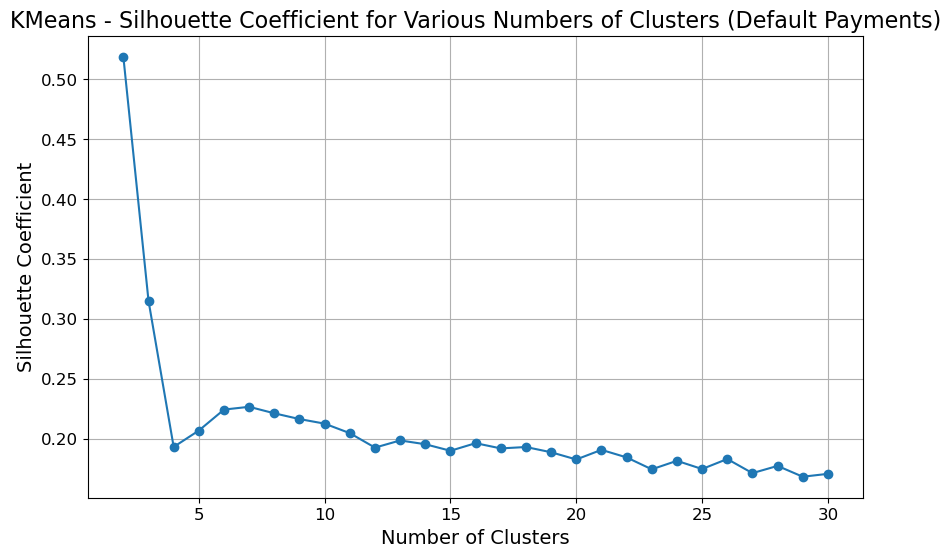

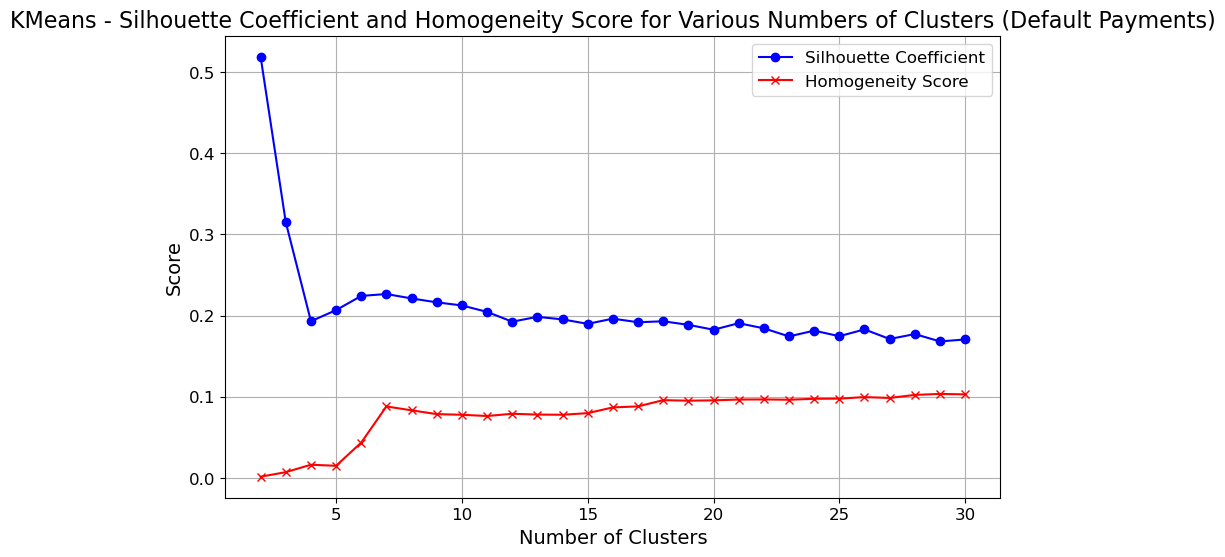

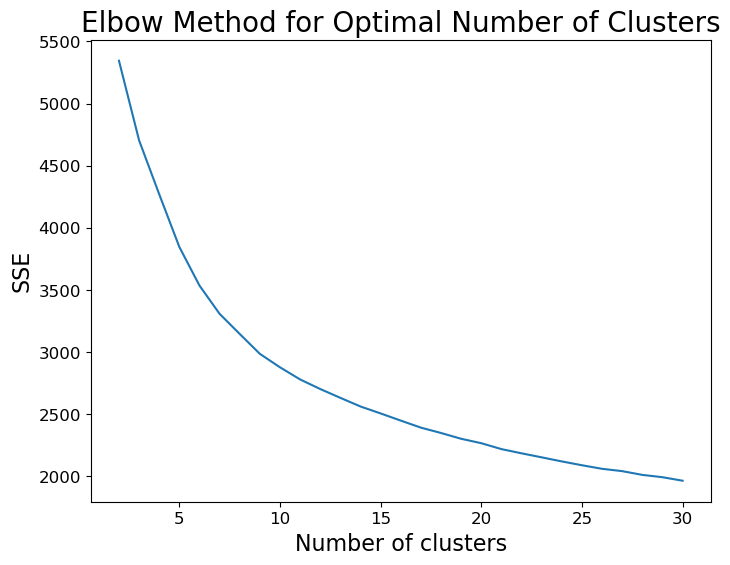

In [125]:
clusters = list(range(2, 31))
silhouette_coeffs = {}
homogeneity_scores = {}
sse = {}


for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=42).fit(train_X)
    label = kmeans.labels_

    sil_coeff = silhouette_score(train_X, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    error = kmeans.inertia_

    
    silhouette_coeffs[cluster] = sil_coeff
    homogeneity_scores[cluster] = homog_score
    sse[cluster] = error

    
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The sse is {error}")

    
# Plotting Silhouette Coefficients
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs.keys()), list(silhouette_coeffs.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("KMeans - Silhouette Coefficient for Various Numbers of Clusters (Default Payments)")
plt.grid(True)
plt.savefig('../images/default-payments-kmeans-silhoueete-coefficients.png')
plt.show()

# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs.keys()), list(silhouette_coeffs.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores.keys()), list(homogeneity_scores.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('KMeans - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters (Default Payments)')
plt.grid(True)
plt.savefig('../images/default-payments-kmeans-sihouette-and-homogeneity.png')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters", fontsize=16)
plt.ylabel("SSE",fontsize=16)
plt.title("Elbow Method for Optimal Number of Clusters", fontsize=20)
plt.savefig('../images/default-payments-elbow-sse.png')
plt.show()

For n_clusters=2, The log likelihood is 30.342203050890234
For n_clusters=2, The Silhouette Coefficient is 0.518751415435814
For n_clusters=2, The Davies Bouldin Score is 0.7956625313897825
For n_clusters=2, The Homogeneity Score is 0.001500777519188931
For n_clusters=3, The log likelihood is 35.672572727834336
For n_clusters=3, The Silhouette Coefficient is 0.214244081927986
For n_clusters=3, The Davies Bouldin Score is 3.917236301251016
For n_clusters=3, The Homogeneity Score is 0.010304594354242259
For n_clusters=4, The log likelihood is 39.25277804555205
For n_clusters=4, The Silhouette Coefficient is 0.024437450110822077
For n_clusters=4, The Davies Bouldin Score is 5.391971671890298
For n_clusters=4, The Homogeneity Score is 0.016372957700764718
For n_clusters=5, The log likelihood is 41.38531071277537
For n_clusters=5, The Silhouette Coefficient is 0.07169953177211026
For n_clusters=5, The Davies Bouldin Score is 4.119463050222029
For n_clusters=5, The Homogeneity Score is 0.015

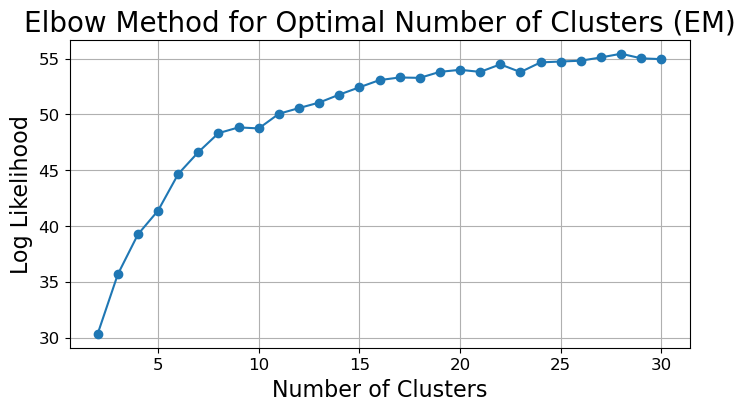

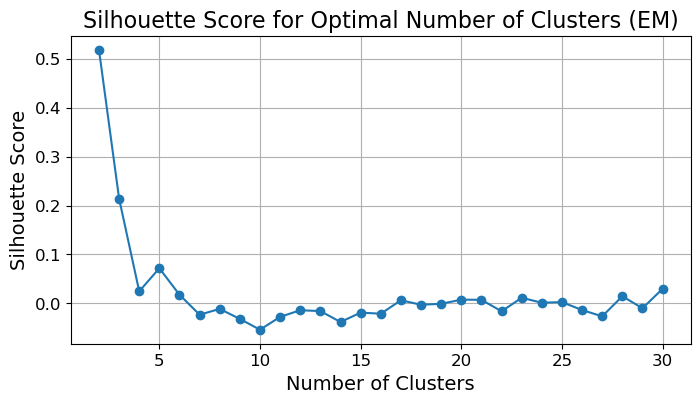

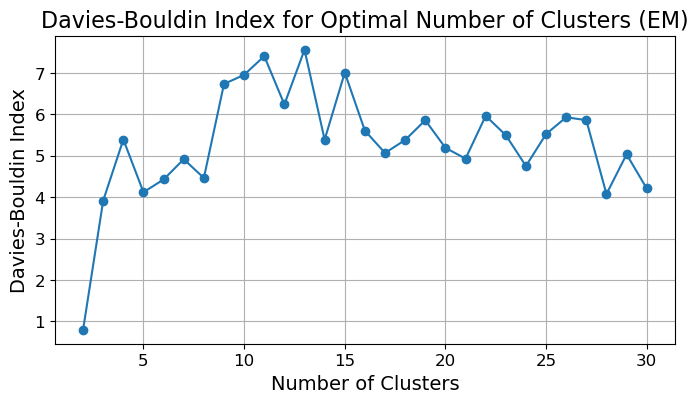

In [126]:
# 	1.	Elbow Method: Look for the “elbow” point in the SSE or log likelihood plots.
#	2.	Silhouette Score: Choose the number of clusters with the highest silhouette score.
#	3.	Davies-Bouldin Index: Choose the number of clusters with the lowest Davies-Bouldin Index.
#	4.	Gap Statistic: Identify the number of clusters with the maximum gap statistic.
clusters = list(range(2, 31))
log_likelihood_em = []
silhouette_scores_em = []
davies_bouldin_scores_em = []
homogeneity_scores_em = []

for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=100, random_state=42).fit(train_X)
    labels = gmm.predict(train_X)
    log_likelihood = gmm.score(train_X)
    silhouette = silhouette_score(train_X, labels)
    davies_bouldin = davies_bouldin_score(train_X, labels)
    homogeneity = homogeneity_score(train_y, labels)
    
    log_likelihood_em.append(log_likelihood)
    silhouette_scores_em.append(silhouette)
    davies_bouldin_scores_em.append(davies_bouldin)    
    homogeneity_scores_em.append(homogeneity)

    print(f"For n_clusters={cluster}, The log likelihood is {log_likelihood}")
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {silhouette}")
    print(f"For n_clusters={cluster}, The Davies Bouldin Score is {davies_bouldin}")
    print(f"For n_clusters={cluster}, The Homogeneity Score is {homogeneity}")

# Plotting Log Likelihood (Elbow Method)
plt.figure(figsize=(8, 4))
plt.plot(clusters, log_likelihood_em, marker='o')
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Log Likelihood", fontsize=16)
plt.title("Elbow Method for Optimal Number of Clusters (EM)", fontsize=20)
plt.grid(True)
plt.savefig('../images/default-payments-em-log-likelihood-elbow-method.png')
plt.show()

# Plotting Silhouette Score
plt.figure(figsize=(8, 4))
plt.plot(clusters, silhouette_scores_em, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Number of Clusters (EM)")
plt.grid(True)
plt.savefig('../images/default-payments-em-sihouette-coefficients.png')
plt.show()

# Plotting Davies-Bouldin Index
plt.figure(figsize=(8, 4))
plt.plot(clusters, davies_bouldin_scores_em, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index for Optimal Number of Clusters (EM)")
plt.grid(True)
plt.savefig('../images/default-payments-em-davies-bouldin-index.png')
plt.show()

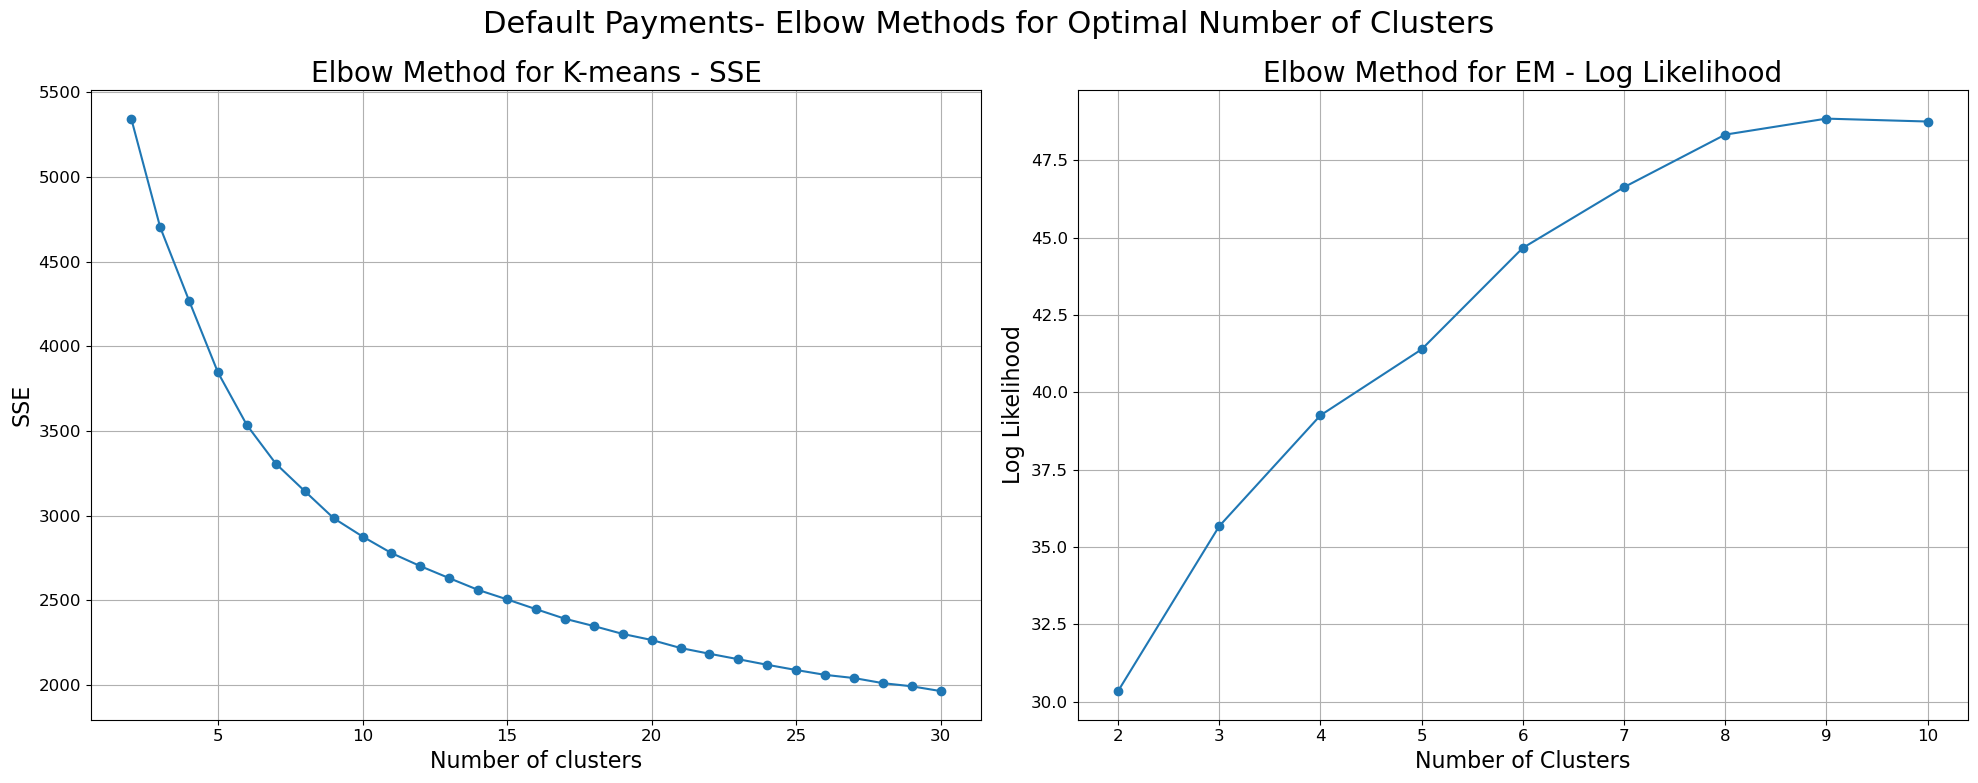

In [117]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot SSE (K-means) on the left subplot
ax1.plot(list(sse.keys()), list(sse.values()), marker='o')
ax1.set_xlabel("Number of clusters", fontsize=16)
ax1.set_ylabel("SSE", fontsize=16)
ax1.set_title("Elbow Method for K-means - SSE", fontsize=20)
ax1.grid(True)

# Plot Log Likelihood (EM) on the right subplot
ax2.plot(clusters, log_likelihood_em, marker='o')
ax2.set_xlabel("Number of Clusters", fontsize=16)
ax2.set_ylabel("Log Likelihood", fontsize=16)
ax2.set_title("Elbow Method for EM - Log Likelihood", fontsize=20)
ax2.grid(True)

# Adjust the layout and add a main title
plt.tight_layout()
fig.suptitle("Default Payments- Elbow Methods for Optimal Number of Clusters", fontsize=22)
plt.subplots_adjust(top=0.88)  # Adjust top margin to accommodate the main title

# Save the figure
plt.savefig('../images/default-combined_elbow_methods.png')

# Show the plot
plt.show()

In [127]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(train_X)
kmeans_labels = kmeans.labels_

In [128]:
print(kmeans_labels)

[2 5 1 ... 4 5 3]


In [129]:
train_X['KMeans_Cluster'] = kmeans_labels

In [130]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(train_X.drop(columns=['KMeans_Cluster']))
gmm_labels = gmm.predict(train_X.drop(columns=['KMeans_Cluster']))

In [131]:
train_X['GMM_Cluster'] = gmm_labels
print(train_X.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   0.020202  0.0   0.333333  0.666667  0.068966    0.2    0.2    0.2    0.2   
1   0.141414  1.0   0.166667  0.666667  0.086207    0.2    0.2    0.2    0.2   
2   0.060606  1.0   0.500000  0.333333  0.189655    0.2    0.2    0.2    0.2   
3   0.121212  0.0   0.500000  0.666667  0.482759    0.2    0.2    0.2    0.2   
4   0.040404  1.0   0.333333  0.666667  0.258621    0.2    0.2    0.2    0.2   

   PAY_5  PAY_6  BILL_AMT5  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0    0.2    0.2   0.094248  0.001717  0.001187  0.001674  0.002415  0.003517   
1    0.2    0.2   0.157733  0.005135  0.002514  0.003528  0.004262  0.006257   
2    0.2    0.2   0.150168  0.002783  0.001848  0.003348  0.003926  0.005861   
3    0.2    0.1   0.091789  0.001843  0.001073  0.007828  0.000043  0.016437   
4    0.2    0.4   0.100772  0.002290  0.000891  0.001116  0.002899  0.000000   

   PAY_AMT6  KMeans_Cluster  GMM_Clust

In [132]:
features_to_plot = ['MARRIAGE', 'AGE']
# Get unique clusters for KMeans and GMM
unique_clusters_kmeans = np.unique(train_X['KMeans_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

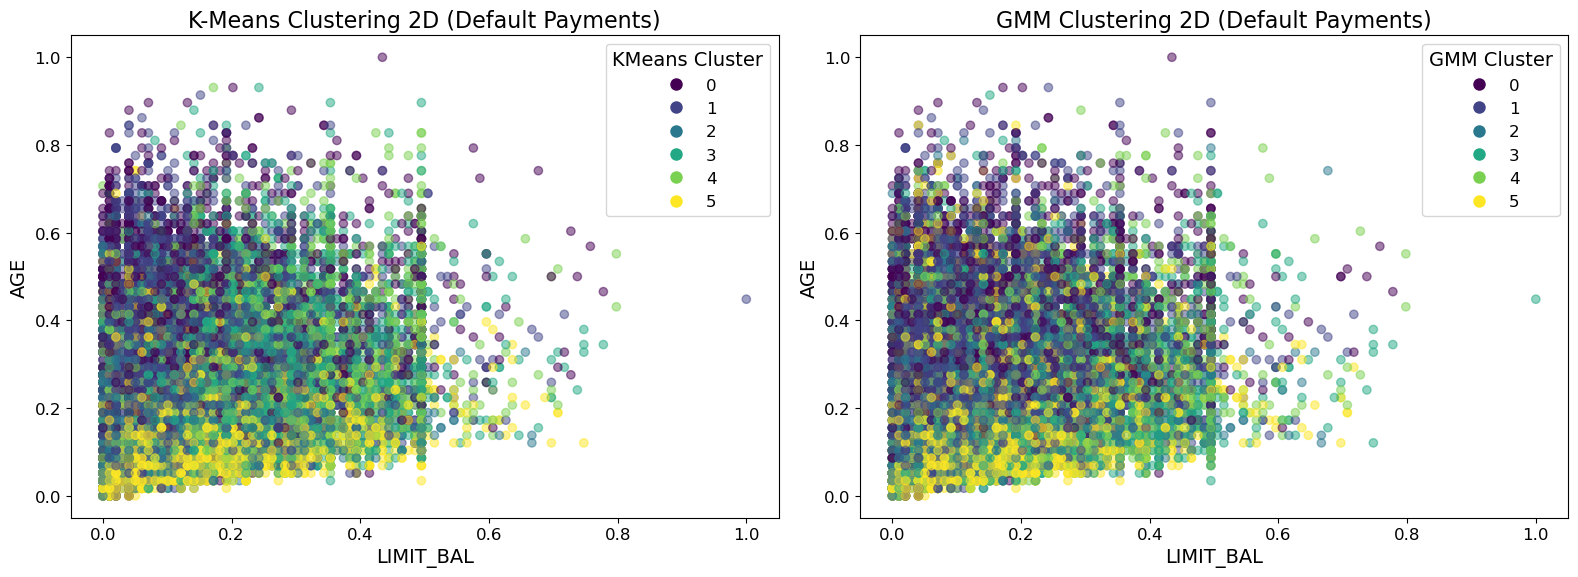

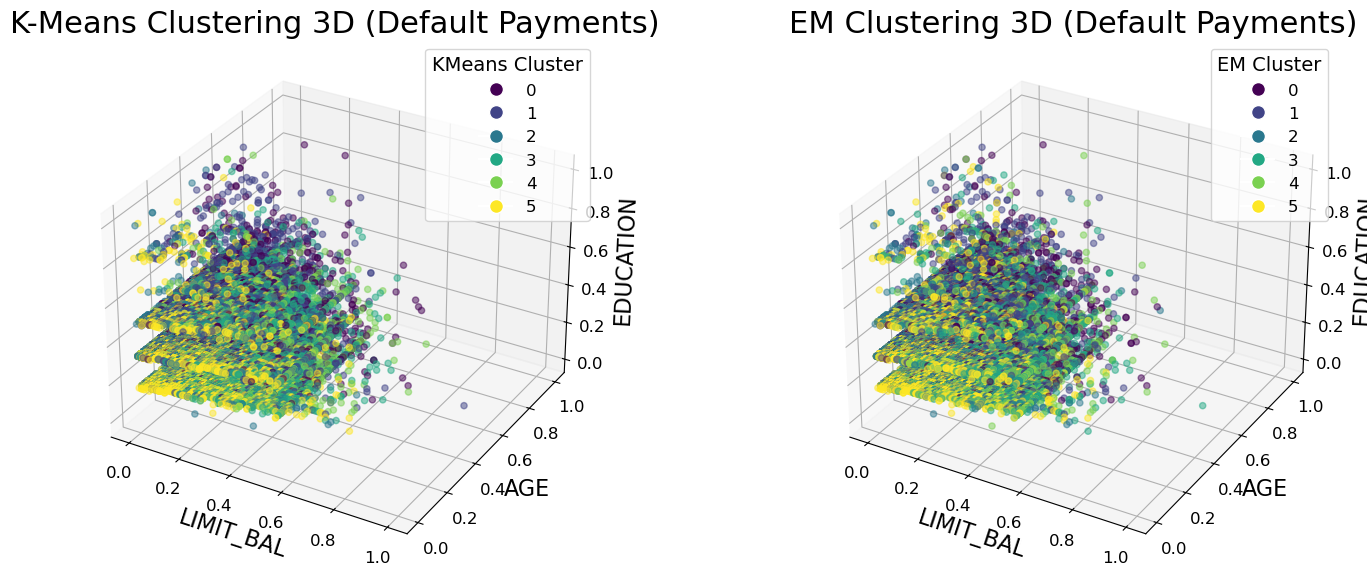

In [133]:
# Define the features you want to plot
features_to_plot_2d = ['LIMIT_BAL', 'AGE']
features_to_plot_3d = ['LIMIT_BAL', 'AGE', 'EDUCATION']

# Create a figure for 2D plots
fig_2d = plt.figure(figsize=(16, 6))

# 2D Plot for K-Means clustering results
ax1 = fig_2d.add_subplot(121)
scatter_kmeans = ax1.scatter(train_X[features_to_plot_2d[0]], train_X[features_to_plot_2d[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('K-Means Clustering 2D (Default Payments)')
ax1.set_xlabel(features_to_plot_2d[0])
ax1.set_ylabel(features_to_plot_2d[1])
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=10) for cluster in unique_clusters_kmeans]
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# 2D Plot for GMM clustering results
ax2 = fig_2d.add_subplot(122)
scatter_gmm = ax2.scatter(train_X[features_to_plot_2d[0]], train_X[features_to_plot_2d[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('GMM Clustering 2D (Default Payments)')
ax2.set_xlabel(features_to_plot_2d[0])
ax2.set_ylabel(features_to_plot_2d[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Save the 2D plots
plt.tight_layout()
plt.savefig('../images/default-payments-clustering-2D-comparison.png')
plt.show()

# Create a figure for 3D plots
fig_3d = plt.figure(figsize=(16, 6))

# 3D Plot for K-Means clustering results
ax1 = fig_3d.add_subplot(121, projection='3d')
scatter_kmeans_3d = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('K-Means Clustering 3D (Default Payments)', fontsize=22)
ax1.set_xlabel(features_to_plot_3d[0], fontsize=16)
ax1.set_ylabel(features_to_plot_3d[1], fontsize=16)
ax1.set_zlabel(features_to_plot_3d[2], fontsize=16)
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# 3D Plot for GMM clustering results
ax2 = fig_3d.add_subplot(122, projection='3d')
scatter_gmm_3d = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('EM Clustering 3D (Default Payments)', fontsize=22)
ax2.set_xlabel(features_to_plot_3d[0], fontsize=16)
ax2.set_ylabel(features_to_plot_3d[1], fontsize=16)
ax2.set_zlabel(features_to_plot_3d[2], fontsize=16)
ax2.legend(handles_gmm, unique_clusters_gmm, title='EM Cluster', loc='best')

# Save the 3D plots
plt.tight_layout()
plt.savefig('../images/default-payments-clustering-3D-comparison.png')
plt.show()

In [72]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Adjusted Rand Index (ARI) between KMeans and GMM clusters: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Normalized Mutual Information (NMI) between KMeans and GMM clusters: {nmi_score}')

Adjusted Rand Index (ARI) between KMeans and GMM clusters: 0.4933061900100088
Normalized Mutual Information (NMI) between KMeans and GMM clusters: 0.5990926509566942


# Neural Networks

## K-Means

In [73]:
# Ensure train_X_grp and train_y are pandas DataFrames/Series
train_X_kmeans = pd.DataFrame(kmeans_labels)
train_y_kmeans = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index_kmeans, test_index_kmeans in split.split(train_X_kmeans, train_y_kmeans):
    strat_train_set_kmeans = train_X_kmeans.iloc[train_index_kmeans]
    strat_test_set_kmeans = train_X_kmeans.iloc[test_index_kmeans]
    strat_train_labels_kmeans = train_y_kmeans.iloc[train_index_kmeans]
    strat_test_labels_kmeans = train_y_kmeans.iloc[test_index_kmeans]

train_X_kmeans = strat_train_set_kmeans
test_X_kmeans = strat_test_set_kmeans
train_y_kmeans = strat_train_labels_kmeans
test_y_kmeans = strat_test_labels_kmeans

In [74]:
neural_net_kmeans = MLPClassifier(random_state=42)
neural_net_kmeans.fit(train_X_kmeans, train_y_kmeans)

MLPClassifier(random_state=42)

In [29]:
%%time
# Evaluate on training data
train_predictions_kmeans = neural_net_kmeans.predict(train_X_kmeans)
train_accuracy_kmeans = accuracy_score(train_y_kmeans, train_predictions_kmeans)
train_roc_auc_kmeans = roc_auc_score(train_y_kmeans, train_predictions_kmeans)
train_precision_kmeans = precision_score(train_y_kmeans, train_predictions_kmeans)
train_recall_kmeans = recall_score(train_y_kmeans, train_predictions_kmeans)
train_f1_kmeans = f1_score(train_y_kmeans, train_predictions_kmeans)

print("Training Accuracy K-Means:", train_accuracy_kmeans)
print("Training ROC AUC Score K-Means:", train_roc_auc_kmeans)
print("Training Precision K-Means:", train_precision_kmeans)
print("Training Recall K-Means:", train_recall_kmeans)
print("Training F1 Score K-Means:", train_f1_kmeans)
train_report_kmeans = classification_report(train_y_kmeans, train_predictions_kmeans)
print(train_report_kmeans)

# Write to a text file
with open('../results/default-payments-nn-kmeans-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy K-Means: " + str(train_accuracy_kmeans) + "\n")
    file.write("Training ROC AUC Score K-Means: " + str(train_roc_auc_kmeans) + "\n")
    file.write("Training Precision K-Means: " + str(train_precision_kmeans) + "\n")
    file.write("Training Recall K-Means: " + str(train_recall_kmeans) + "\n")
    file.write("Training F1 Score K-Means: " + str(train_f1_kmeans) + "\n")
    file.write("\nClassification Report K-Means:\n")
    file.write(train_report_kmeans + "\n")

Training Accuracy K-Means: 0.7914583333333334
Training ROC AUC Score K-Means: 0.5611987628523841
Training Precision K-Means: 0.6196850393700788
Training Recall K-Means: 0.14823883970615936
Training F1 Score K-Means: 0.23924608603131176
              precision    recall  f1-score   support

           0       0.80      0.97      0.88     18691
           1       0.62      0.15      0.24      5309

    accuracy                           0.79     24000
   macro avg       0.71      0.56      0.56     24000
weighted avg       0.76      0.79      0.74     24000

CPU times: user 129 ms, sys: 530 ms, total: 659 ms
Wall time: 72 ms


In [30]:
%%time
# Evaluate testing data
test_predictions_kmeans = neural_net_kmeans.predict(test_X_kmeans)
test_accuracy_kmeans = accuracy_score(test_y_kmeans, test_predictions_kmeans)
test_roc_auc_kmeans = roc_auc_score(test_y_kmeans, test_predictions_kmeans)
test_precision_kmeans = precision_score(test_y_kmeans, test_predictions_kmeans)
test_recall_kmeans = recall_score(test_y_kmeans, test_predictions_kmeans)
test_f1_kmeans = f1_score(test_y_kmeans, test_predictions_kmeans)

print("Testing Accuracy K-Means:", test_accuracy_kmeans)
print("Testing ROC AUC Score K-Means:", test_roc_auc_kmeans)
print("Testing Precision K-Means:", test_precision_kmeans)
print("Testing Recall K-Means:", test_recall_kmeans)
print("Testing F1 Score K-Means:", test_f1_kmeans)
test_report_kmeans = classification_report(test_y_kmeans, test_predictions_kmeans)
print(test_report_kmeans)

# Write to a text file
with open('../results/default-payments-nn-kmeans-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy K-Means: " + str(test_accuracy_kmeans) + "\n")
    file.write("Testing ROC AUC Score K-Means: " + str(test_roc_auc_kmeans) + "\n")
    file.write("Testing Precision K-Means: " + str(test_precision_kmeans) + "\n")
    file.write("Testing Recall K-Means: " + str(test_recall_kmeans) + "\n")
    file.write("Testing F1 Score K-Means: " + str(test_f1_kmeans) + "\n")
    file.write("\nClassification Report K-Means:\n")
    file.write(test_report_kmeans + "\n")

Testing Accuracy K-Means: 0.7965
Testing ROC AUC Score K-Means: 0.5690772610086225
Testing Precision K-Means: 0.6645962732919255
Testing Recall K-Means: 0.16126601356443104
Testing F1 Score K-Means: 0.25955124317768347
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4673
           1       0.66      0.16      0.26      1327

    accuracy                           0.80      6000
   macro avg       0.73      0.57      0.57      6000
weighted avg       0.77      0.80      0.74      6000

CPU times: user 78.4 ms, sys: 222 ms, total: 301 ms
Wall time: 36.8 ms


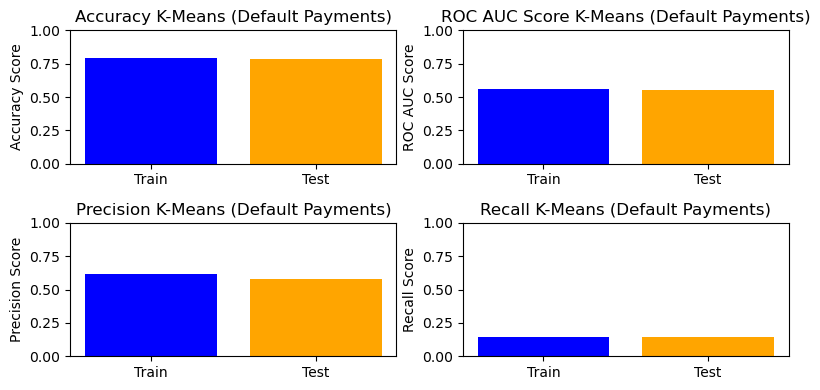

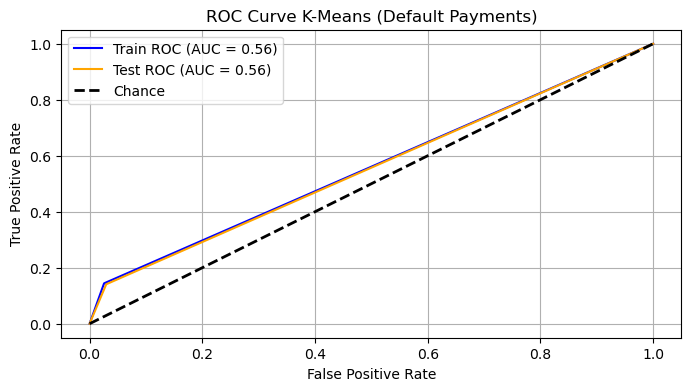

CPU times: user 1.16 s, sys: 1.15 s, total: 2.31 s
Wall time: 350 ms


In [20]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy_kmeans, test_accuracy_kmeans], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy K-Means (Default Payments)')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc_kmeans, test_roc_auc_kmeans], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score K-Means (Default Payments)')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision_kmeans, test_precision_kmeans], color=['blue', 'orange'])
ax[1, 0].set_title('Precision K-Means (Default Payments)')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall_kmeans, test_recall_kmeans], color=['blue', 'orange'])
ax[1, 1].set_title('Recall K-Means (Default Payments)')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/default-payments-nn-kmeans-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr_kmeans, train_tpr_kmeans, _ = roc_curve(train_y_kmeans, train_predictions_kmeans)
test_fpr_kmeans, test_tpr_kmeans, _ = roc_curve(test_y_kmeans, test_predictions_kmeans)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr_kmeans, train_tpr_kmeans, label=f'Train ROC (AUC = {auc(train_fpr_kmeans, train_tpr_kmeans):.2f})', color='blue')
plt.plot(test_fpr_kmeans, test_tpr_kmeans, label=f'Test ROC (AUC = {auc(test_fpr_kmeans, test_tpr_kmeans):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve K-Means (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-kmeans-roc-curve')
plt.show()

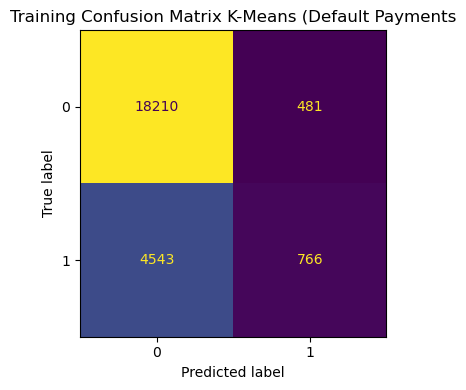

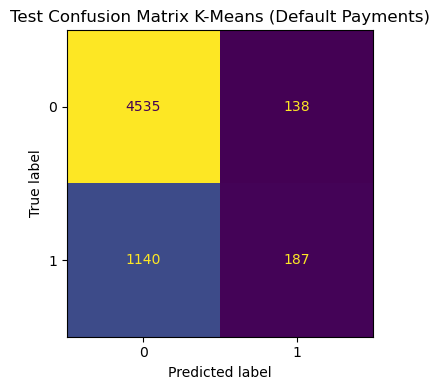

CPU times: user 375 ms, sys: 12.1 ms, total: 387 ms
Wall time: 130 ms


In [21]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm_kmeans = confusion_matrix(train_y_kmeans, train_predictions_kmeans)
ConfusionMatrixDisplay(train_cm_kmeans).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix K-Means (Default Payments")
plt.tight_layout()
plt.savefig('../images/default-payments-nn-kmeans-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm_kmeans = confusion_matrix(test_y_kmeans, test_predictions_kmeans)
ConfusionMatrixDisplay(test_cm_kmeans).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix K-Means (Default Payments)')
plt.tight_layout()
plt.savefig('../images/default-payments-nn-kmeans-testing-cm.png')
plt.show()

Training progress:  10%|███████▌                                                                   | 1/10 [00:01<00:09,  1.07s/it]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training progress:  20%|███████████████                                                            | 2/10 [00:03<00:15,  2.00s/it]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Training progress:  30%|██████████████████████▌                                                    | 3/10 [00:11<00:32,  4.67s/it]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/py

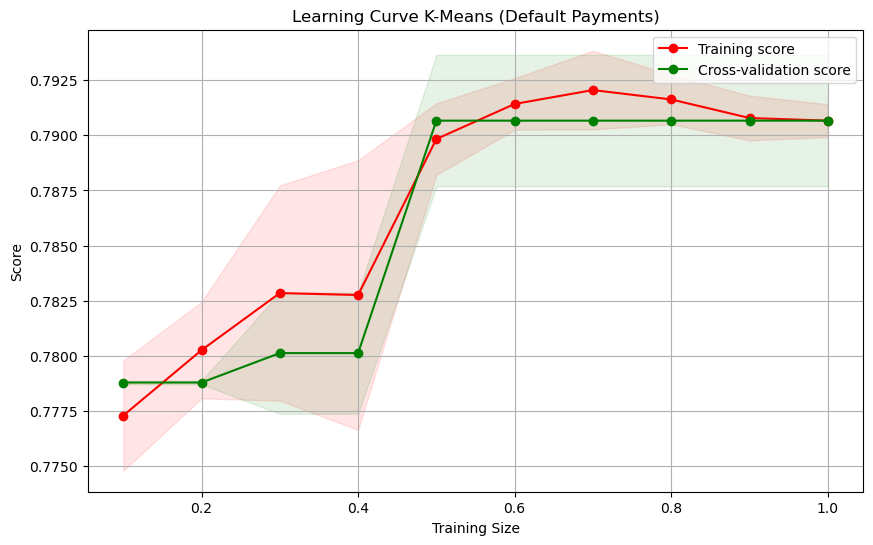

CPU times: user 17min 17s, sys: 41.1 s, total: 17min 58s
Wall time: 1min 54s


In [22]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes_kmeans = np.linspace(0.1, 1.0, 10)
train_sizes_kmeans, train_scores_kmeans, test_scores_kmeans = learning_curve_with_progress(neural_net_kmeans, train_X_kmeans, train_y_kmeans, cv=5, scoring='accuracy', train_sizes=train_sizes_kmeans)

train_scores_mean_kmeans = np.mean(train_scores_kmeans, axis=1)
train_scores_std_kmeans = np.std(train_scores_kmeans, axis=1)
test_scores_mean_kmeans = np.mean(test_scores_kmeans, axis=1)
test_scores_std_kmeans = np.std(test_scores_kmeans, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes_kmeans, train_scores_mean_kmeans - train_scores_std_kmeans,
                 train_scores_mean_kmeans + train_scores_std_kmeans, alpha=0.1, color='r')
plt.fill_between(train_sizes_kmeans, test_scores_mean_kmeans - test_scores_std_kmeans,
                 test_scores_mean_kmeans + test_scores_std_kmeans, alpha=0.1, color='g')

plt.plot(train_sizes_kmeans, train_scores_mean_kmeans, 'o-', color='r', label='Training score')
plt.plot(train_sizes_kmeans, test_scores_mean_kmeans, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve K-Means (Default Payments)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-kmeans-learning-curve-training-size.png')
plt.show()

In [118]:
def validation_curve_with_time(estimator, X, y, param_name, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)
    
    train_times = []
    for param in param_range:
        start_time = time.time()
        estimator.set_params(**{param_name: param})
        estimator.fit(X, y)
        train_times.append(time.time() - start_time)
    
    return train_scores, test_scores, train_times

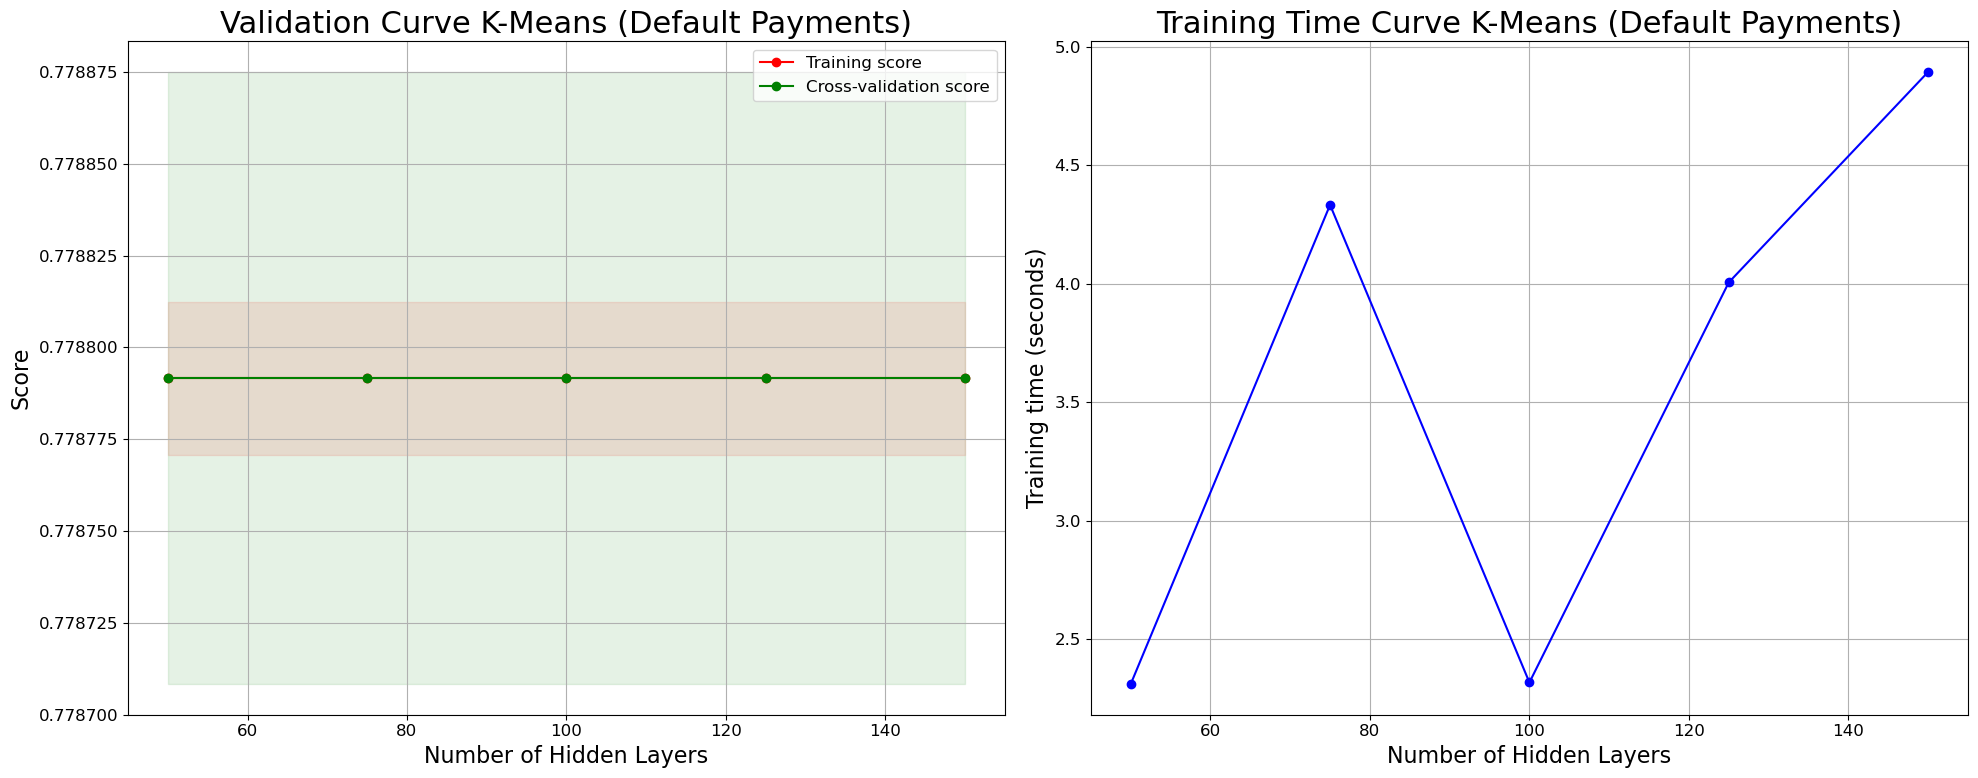

In [122]:
param_range = [50, 75, 100, 125, 150]
train_scores, test_scores, train_times = validation_curve_with_time(
    MLPClassifier(), train_X_kmeans, train_y_kmeans, "hidden_layer_sizes", 
    param_range, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Validation curve
ax1.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
ax1.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax1.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax1.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.set_title('Validation Curve K-Means (Default Payments)', fontsize=22)
ax1.set_xlabel('Number of Hidden Layers', fontsize=16)
ax1.set_ylabel('Score', fontsize=16)
ax1.legend(loc="best", fontsize=14)
ax1.grid()

# Adjust y-axis limits for validation curve
y_min = min(min(train_scores_mean - train_scores_std), min(test_scores_mean - test_scores_std))
y_max = max(max(train_scores_mean + train_scores_std), max(test_scores_mean + test_scores_std))
ax1.set_ylim(y_min - 0.02 * (y_max - y_min), y_max + 0.02 * (y_max - y_min))

# Time curve
ax2.plot(param_range, train_times, 'o-', color='b')
ax2.set_title('Training Time Curve K-Means (Default Payments)', fontsize=22)
ax2.set_xlabel('Number of Hidden Layers', fontsize=16)
ax2.set_ylabel('Training time (seconds)', fontsize=16)
ax2.grid()

# Adjust y-axis limits for time curve
y_min_time = min(train_times)
y_max_time = max(train_times)
ax2.set_ylim(y_min_time - 0.02 * (y_max_time - y_min_time), y_max_time + 0.02 * (y_max_time - y_min_time))

# Adjust layout and save
plt.tight_layout()
plt.savefig('../images/default-payments-nn-kmeans-validation-and-time-curves.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Validation progress:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.01s/it]


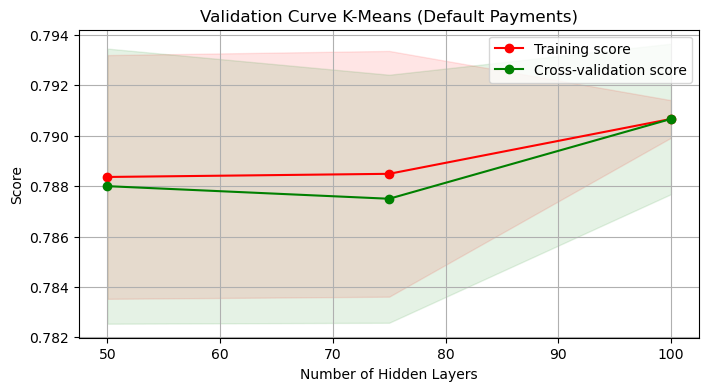

CPU times: user 354 ms, sys: 1.2 s, total: 1.55 s
Wall time: 9.2 s


In [23]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_kmeans, train_y_kmeans, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve K-Means (Default Payments)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-kmeans-validation-curve-hidden-layers.png')
plt.show()

Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


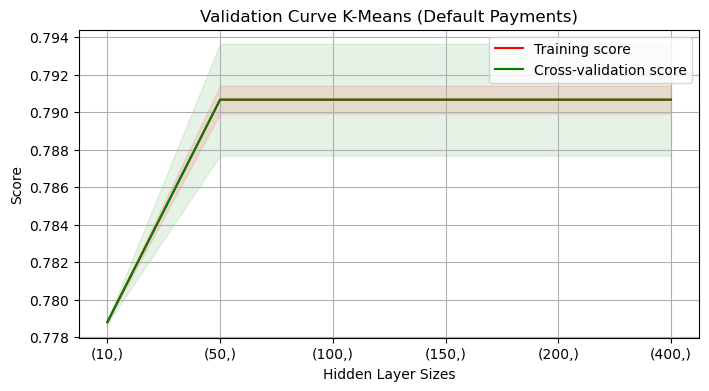

CPU times: user 772 ms, sys: 159 ms, total: 931 ms
Wall time: 15.1 s


In [24]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_kmeans, train_y_kmeans, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve K-Means (Default Payments)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-kmeans-validation-curve-hidden-layer-sizes-2.png')
plt.show()

Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


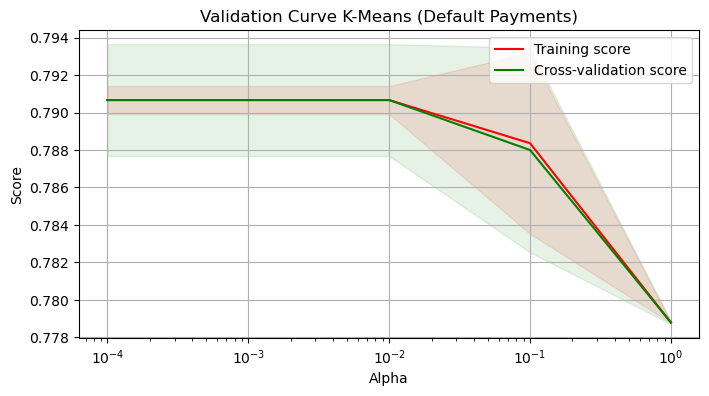

CPU times: user 1.11 s, sys: 48.1 ms, total: 1.16 s
Wall time: 10 s


In [25]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X_kmeans, train_y_kmeans, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve K-Means (Default Payments)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-kmeans-validation-curve-alpha.png')
plt.show()

In [26]:
%%time
# Perform 10-fold cross-validation
cv_scores_kmeans = cross_val_score(neural_net_kmeans, train_X_kmeans, train_y_kmeans, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores_kmeans)
print("mean cross-validation score:", cv_scores_kmeans.mean())

# Write cross-validation scores to a text file
with open('../results/default-payments-nn-kmeans-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores_kmeans) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores_kmeans.mean()) + "\n")

Cross-validation scores: [0.77958333 0.79166667 0.78958333 0.79333333 0.79625    0.78291667
 0.79375    0.79541667 0.79416667 0.79      ]
mean cross-validation score: 0.7906666666666666
CPU times: user 5min 17s, sys: 10.7 s, total: 5min 28s
Wall time: 35.2 s


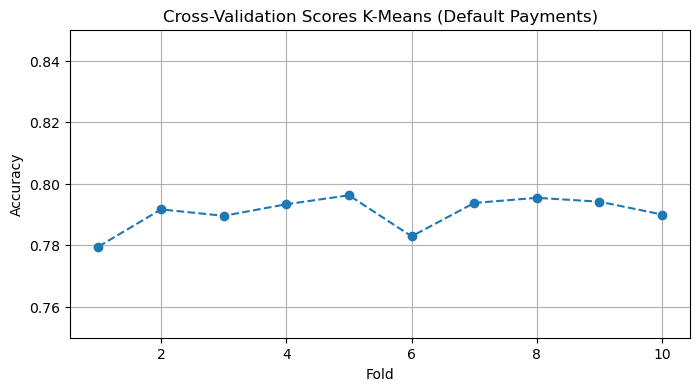

In [27]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores_kmeans, marker='o', linestyle='--')
plt.title('Cross-Validation Scores K-Means (Default Payments)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/default-payments-nn-kmeans-cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     18691
           1       0.61      0.14      0.23      5309

    accuracy                           0.79     24000
   macro avg       0.71      0.56      0.56     24000
weighted avg       0.76      0.79      0.74     24000



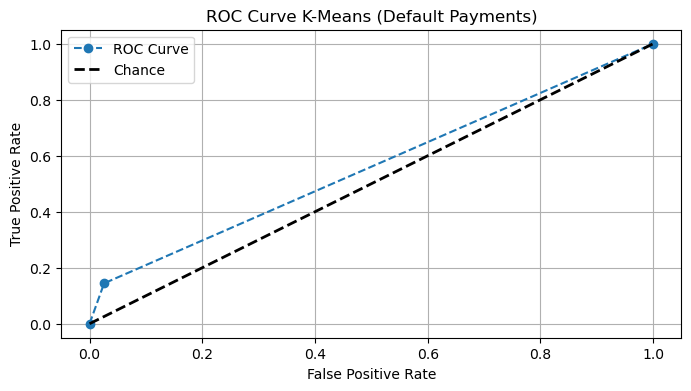

CPU times: user 5min 16s, sys: 8.48 s, total: 5min 25s
Wall time: 34.6 s


In [28]:
%%time
y_pred_kmeans = cross_val_predict(neural_net_kmeans, train_X_kmeans, train_y_kmeans, cv=10)

report = classification_report(train_y_kmeans, y_pred_kmeans)
print(report)

with open('../results/default-payments-nn-kmeans-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y_kmeans, y_pred_kmeans, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve K-Means (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-kmeans-roc-curve-fpr.png')
plt.show()

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

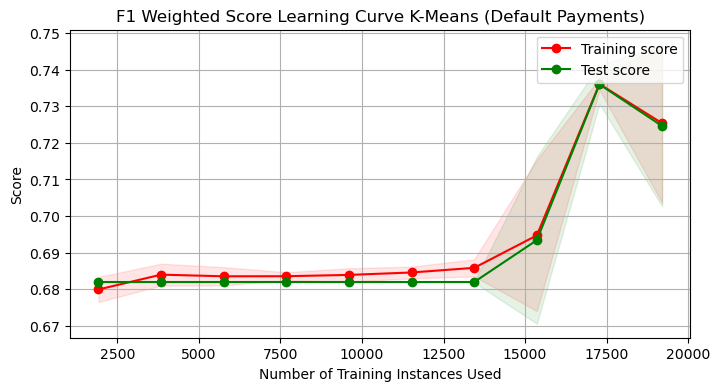

CPU times: user 619 ms, sys: 133 ms, total: 751 ms
Wall time: 6.51 s


In [29]:
%%time
best_mlp_kmeans = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_kmeans, train_X_kmeans, train_y_kmeans, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve K-Means (Default Payments)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-kmeans-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/default-payments-nn-kmeans-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report_kmeans + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm_kmeans) + "\n")

## Expectation Maximization

In [79]:
train_X_em = pd.DataFrame(gmm_labels)
train_y_em = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index_em, test_index_em in split.split(train_X_em, train_y_em):
    strat_train_set_em = train_X_em.iloc[train_index_em]
    strat_test_set_em = train_X_em.iloc[test_index_em]
    strat_train_labels_em = train_y_em.iloc[train_index_em]
    strat_test_labels_em = train_y_em.iloc[test_index_em]

train_X_em = strat_train_set_em
test_X_em = strat_test_set_em
train_y_em = strat_train_labels_em
test_y_em = strat_test_labels_em

In [80]:
neural_net_em = MLPClassifier()
neural_net_em.fit(train_X_em, train_y_em)

MLPClassifier()

In [27]:
%%time
# Evaluate on training data
train_predictions_em = neural_net_em.predict(train_X_em)
train_accuracy_em = accuracy_score(train_y_em, train_predictions_em)
train_roc_auc_em = roc_auc_score(train_y_em, train_predictions_em)
train_precision_em = precision_score(train_y_em, train_predictions_em)
train_recall_em = recall_score(train_y_em, train_predictions_em)
train_f1_em = f1_score(train_y_em, train_predictions_em)

print("Training Accuracy Expectation Maximization:", train_accuracy_em)
print("Training ROC AUC Score Expectation Maximization:", train_roc_auc_em)
print("Training Precision Expectation Maximization:", train_precision_em)
print("Training Recall Expectation Maximization:", train_recall_em)
print("Training F1 Score Expectation Maximization:", train_f1_em)
train_report_em = classification_report(train_y_em, train_predictions_em)
print(train_report_em)

# Write to a text file
with open('../results/default-payments-nn-em-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy Expectation Maximization: " + str(train_accuracy_em) + "\n")
    file.write("Training ROC AUC Score Expectation Maximization: " + str(train_roc_auc_em) + "\n")
    file.write("Training Precision Expectation Maximization: " + str(train_precision_em) + "\n")
    file.write("Training Recall Expectation Maximization: " + str(train_recall_em) + "\n")
    file.write("Training F1 Score Expectation Maximization: " + str(train_f1_em) + "\n")
    file.write("\nClassification Report Expectation Maximization:\n")
    file.write(train_report_em + "\n")

Training Accuracy Expectation Maximization: 0.7787916666666667
Training ROC AUC Score Expectation Maximization: 0.5
Training Precision Expectation Maximization: 0.0
Training Recall Expectation Maximization: 0.0
Training F1 Score Expectation Maximization: 0.0
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

CPU times: user 229 ms, sys: 436 ms, total: 665 ms
Wall time: 85.5 ms


/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

In [50]:
%%time
# Evaluate testing data
test_predictions_em = neural_net_em.predict(test_X_em)
test_accuracy_em = accuracy_score(test_y_em, test_predictions_em)
test_roc_auc_em = roc_auc_score(test_y_em, test_predictions_em)
test_precision_em = precision_score(test_y_em, test_predictions_em)
test_recall_em = recall_score(test_y_em, test_predictions_em)
test_f1_em = f1_score(test_y_em, test_predictions_em)

print("Testing Accuracy Expectation Maximization:", test_accuracy_em)
print("Testing ROC AUC Score Expectation Maximization:", test_roc_auc_em)
print("Testing Precision Expectation Maximization:", test_precision_em)
print("Testing Recall Expectation Maximization:", test_recall_em)
print("Testing F1 Score Expectation Maximization:", test_f1_em)
test_report_em = classification_report(test_y_em, test_predictions_em)
print(test_report_em)

# Write to a text file
with open('../results/default-payments-nn-em-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy Expectation Maximization: " + str(test_accuracy_em) + "\n")
    file.write("Testing ROC AUC Score Expectation Maximization: " + str(test_roc_auc_em) + "\n")
    file.write("Testing Precision Expectation Maximization: " + str(test_precision_em) + "\n")
    file.write("Testing Recall Expectation Maximization: " + str(test_recall_em) + "\n")
    file.write("Testing F1 Score Expectation Maximization: " + str(test_f1_em) + "\n")
    file.write("\nClassification Report Expectation Maximization:\n")
    file.write(test_report_em + "\n")

Testing Accuracy Expectation Maximization: 0.7788333333333334
Testing ROC AUC Score Expectation Maximization: 0.5
Testing Precision Expectation Maximization: 0.0
Testing Recall Expectation Maximization: 0.0
Testing F1 Score Expectation Maximization: 0.0
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000

CPU times: user 265 ms, sys: 110 ms, total: 375 ms
Wall time: 60.8 ms


/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

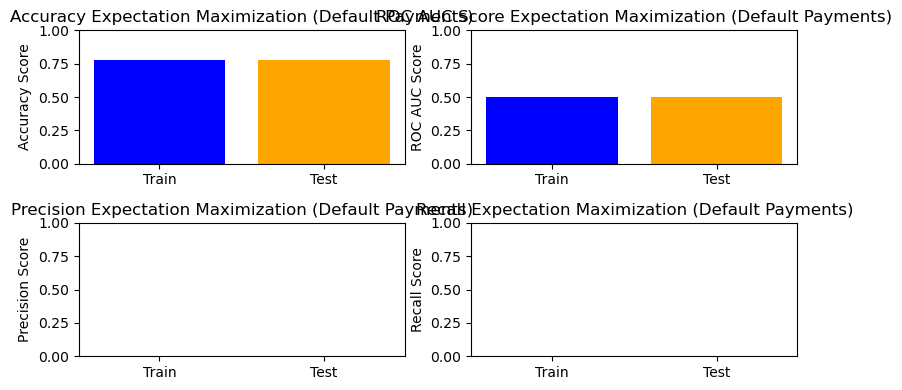

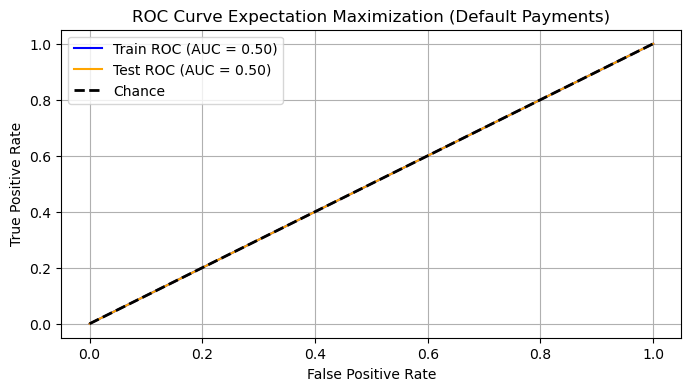

CPU times: user 1.1 s, sys: 1.27 s, total: 2.37 s
Wall time: 349 ms


In [34]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy_em, test_accuracy_em], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy Expectation Maximization (Default Payments)')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc_em, test_roc_auc_em], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score Expectation Maximization (Default Payments)')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision_em, test_precision_em], color=['blue', 'orange'])
ax[1, 0].set_title('Precision Expectation Maximization')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall_em, test_recall_em], color=['blue', 'orange'])
ax[1, 1].set_title('Recall Expectation Maximization')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/default-payments-nn-em-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr_em, train_tpr_em, _ = roc_curve(train_y_em, train_predictions_em)
test_fpr_em, test_tpr_em, _ = roc_curve(test_y_em, test_predictions_em)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr_em, train_tpr_em, label=f'Train ROC (AUC = {auc(train_fpr_em, train_tpr_em):.2f})', color='blue')
plt.plot(test_fpr_em, test_tpr_em, label=f'Test ROC (AUC = {auc(test_fpr_em, test_tpr_em):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve Expectation Maximization')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-em-roc-curve')
plt.show()

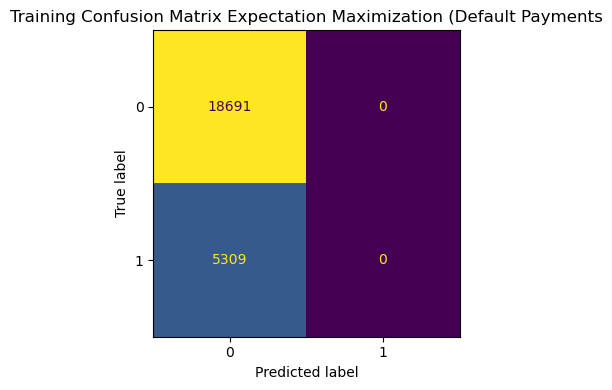

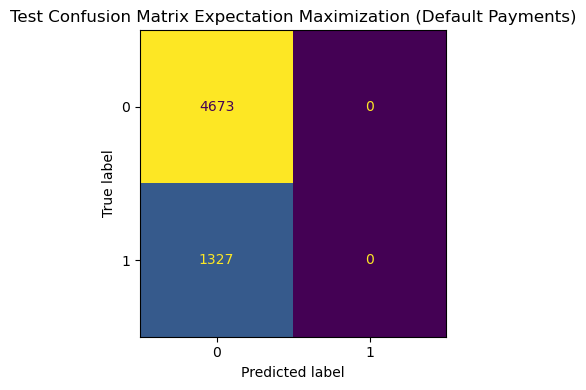

CPU times: user 390 ms, sys: 13.5 ms, total: 404 ms
Wall time: 135 ms


In [35]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm_em = confusion_matrix(train_y_em, train_predictions_em)
ConfusionMatrixDisplay(train_cm_em).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix Expectation Maximization (Default Payments")
plt.tight_layout()
plt.savefig('../images/default-payments-nn-kmeans-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm_em = confusion_matrix(test_y_em, test_predictions_em)
ConfusionMatrixDisplay(test_cm_em).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix Expectation Maximization (Default Payments)')
plt.tight_layout()
plt.savefig('../images/default-payments-nn-em-testing-cm.png')
plt.show()

In [87]:
def validation_curve_with_time(estimator, X, y, param_name, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)
    
    train_times = []
    for param in param_range:
        start_time = time.time()
        estimator.set_params(**{param_name: param})
        estimator.fit(X, y)
        train_times.append(time.time() - start_time)
    
    return train_scores, test_scores, train_times

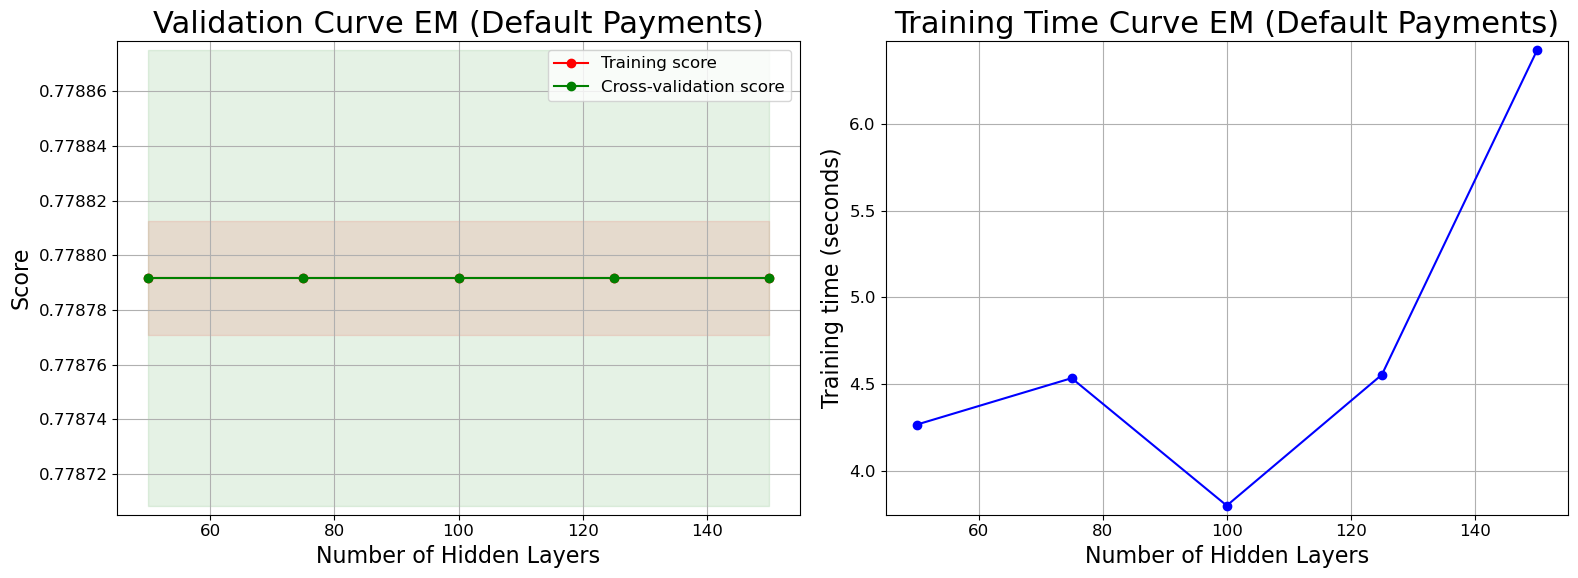

In [124]:
param_range = [50, 75, 100, 125, 150]
train_scores, test_scores, train_times = validation_curve_with_time(
    MLPClassifier(), train_X_em, train_y_em, "hidden_layer_sizes", 
    param_range, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation curve
ax1.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
ax1.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax1.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax1.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.set_title('Validation Curve EM (Default Payments)', fontsize=22)
ax1.set_xlabel('Number of Hidden Layers', fontsize=16)
ax1.set_ylabel('Score', fontsize=16)
ax1.legend(loc="best", fontsize=12)
ax1.grid()

# Adjust y-axis limits for validation curve
y_min = min(min(train_scores_mean - train_scores_std), min(test_scores_mean - test_scores_std))
y_max = max(max(train_scores_mean + train_scores_std), max(test_scores_mean + test_scores_std))
ax1.set_ylim(y_min - 0.02 * (y_max - y_min), y_max + 0.02 * (y_max - y_min))

# Time curve
ax2.plot(param_range, train_times, 'o-', color='b')
ax2.set_title('Training Time Curve EM (Default Payments)', fontsize=22)
ax2.set_xlabel('Number of Hidden Layers', fontsize=16)
ax2.set_ylabel('Training time (seconds)', fontsize=16)
ax2.grid()

# Adjust y-axis limits for time curve
y_min_time = min(train_times)
y_max_time = max(train_times)
ax2.set_ylim(y_min_time - 0.02 * (y_max_time - y_min_time), y_max_time + 0.02 * (y_max_time - y_min_time))

# Adjust layout and save
plt.tight_layout()
plt.savefig('../images/default-payments-nn-em-validation-and-time-curves.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

##### %%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes_em = np.linspace(0.1, 1.0, 10)
train_sizes_em, train_scores_em, test_scores_em = learning_curve_with_progress(neural_net_em, train_X_em, train_y_em, cv=5, scoring='accuracy', train_sizes=train_sizes_kmeans)

train_scores_mean_em = np.mean(train_scores_em, axis=1)
train_scores_std_em = np.std(train_scores_em, axis=1)
test_scores_mean_em = np.mean(test_scores_em, axis=1)
test_scores_std_em = np.std(test_scores_em, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes_em, train_scores_mean_em - train_scores_std_em,
                 train_scores_mean_em + train_scores_std_em, alpha=0.1, color='r')
plt.fill_between(train_sizes_em, test_scores_mean_em - test_scores_std_em,
                 test_scores_mean_em + test_scores_std_em, alpha=0.1, color='g')

plt.plot(train_sizes_em, train_scores_mean_em, 'o-', color='r', label='Training score')
plt.plot(train_sizes_em, test_scores_mean_em, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve Expectation Maximization (Default Payments)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-em-learning-curve-training-size.png')
plt.show()

Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


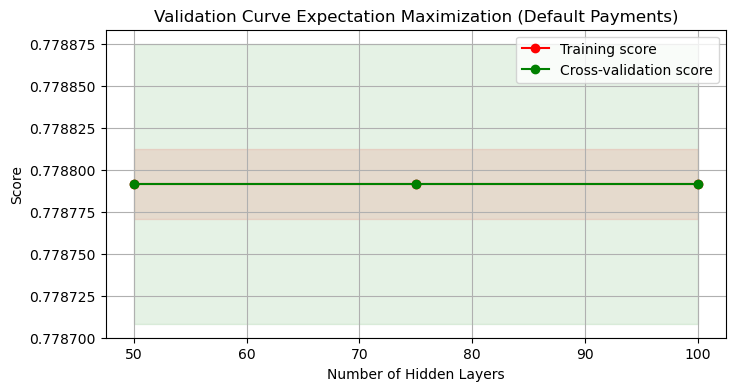

CPU times: user 297 ms, sys: 1.09 s, total: 1.39 s
Wall time: 3.63 s


In [55]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_em, train_y_em, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve Expectation Maximization (Default Payments)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-em-validation-curve-hidden-layers.png')
plt.show()

Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


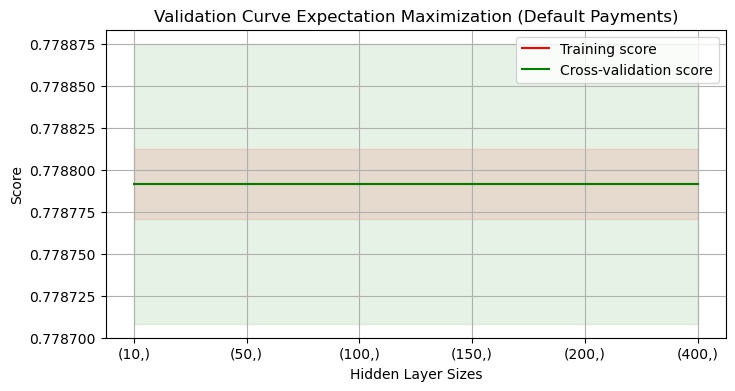

CPU times: user 679 ms, sys: 33.1 ms, total: 712 ms
Wall time: 5.99 s


In [38]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_em, train_y_em, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve Expectation Maximization (Default Payments)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-em-validation-curve-hidden-layer-sizes-2.png')
plt.show()

Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


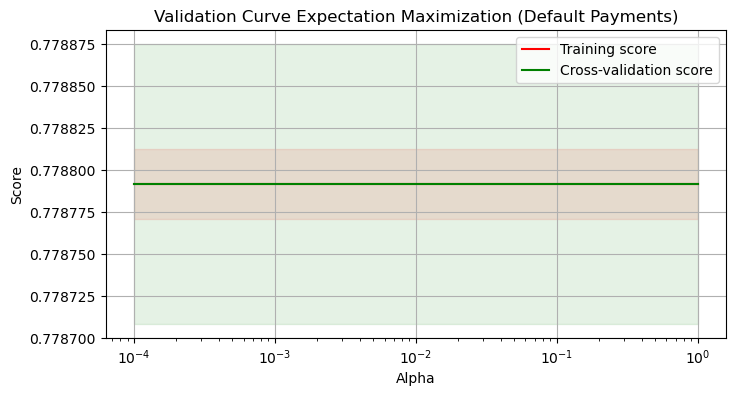

CPU times: user 533 ms, sys: 30.5 ms, total: 564 ms
Wall time: 3.77 s


In [56]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X_em, train_y_em, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve Expectation Maximization (Default Payments)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-em-validation-curve-alpha.png')
plt.show()

In [40]:
%%time
# Perform 10-fold cross-validation
cv_scores_em = cross_val_score(neural_net_em, train_X_em, train_y_em, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores_em)
print("mean cross-validation score:", cv_scores_em.mean())

# Write cross-validation scores to a text file
with open('../results/default-payments-nn-em-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores_em) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores_em.mean()) + "\n")

Cross-validation scores: [0.77916667 0.77875    0.77875    0.77875    0.77875    0.77875
 0.77875    0.77875    0.77875    0.77875   ]
mean cross-validation score: 0.7787916666666668
CPU times: user 2min 1s, sys: 2.17 s, total: 2min 3s
Wall time: 13.5 s


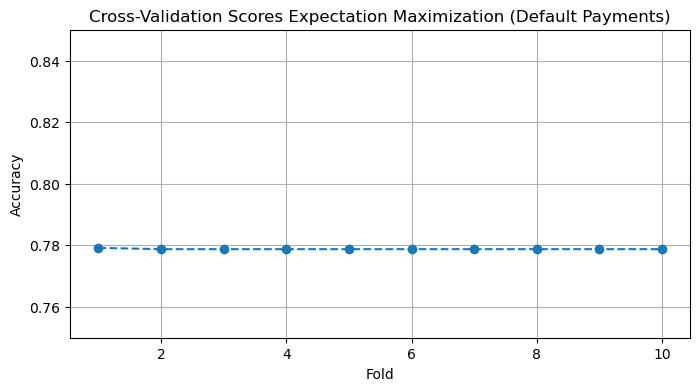

In [41]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores_em, marker='o', linestyle='--')
plt.title('Cross-Validation Scores Expectation Maximization (Default Payments)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/default-payments-nn-em-cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000



/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

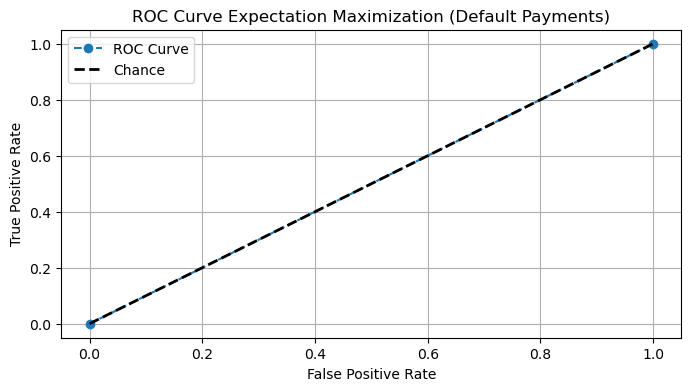

CPU times: user 1min 38s, sys: 9.82 s, total: 1min 47s
Wall time: 11.7 s


In [57]:
%%time
y_pred_em = cross_val_predict(neural_net_em, train_X_em, train_y_em, cv=10)

report = classification_report(train_y_em, y_pred_em)
print(report)

with open('../results/default-payments-nn-em-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y_em, y_pred_em, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve Expectation Maximization (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-em-roc-curve-fpr.png')
plt.show()

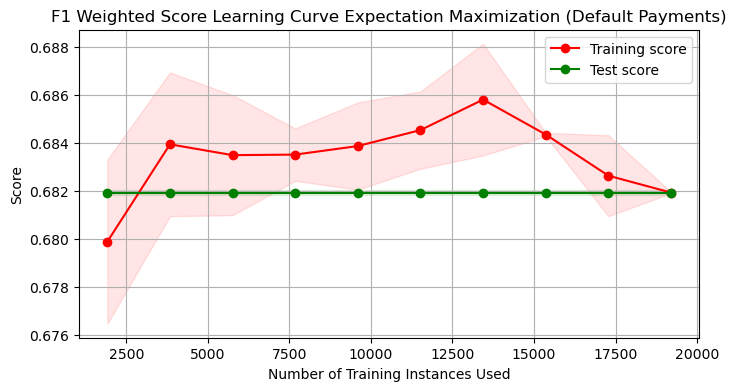

CPU times: user 584 ms, sys: 237 ms, total: 821 ms
Wall time: 2.86 s


In [58]:
%%time
best_mlp_em = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_em, train_X_em, train_y_em, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve Expectation Maximization (Default Payments)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-em-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/default-payments-nn-em-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report_em + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm_em) + "\n")

In [44]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 5.707304952782579
